In [39]:
import cv2
import numpy as np

def enhance_text_readability(image, scale_factor=1, sharpening_strength=1.3, denoise_level=1):
    """
    Улучшает читаемость текста на изображении
    
    Параметры:
    - image: входное изображение (numpy array)
    - scale_factor: коэффициент увеличения (рекомендуется 1.0-1.5)
    - sharpening_strength: сила повышения резкости (1.0-2.0)
    - denoise_level: уровень подавления шумов (1-10)
    
    Возвращает:
    - Улучшенное изображение
    """
    if image is None:
        raise ValueError("Не удалось загрузить изображение")

    # 1. Увеличение разрешения с сохранением деталей
    if scale_factor != 1.0:
        high_res = cv2.resize(image, None, fx=scale_factor, fy=scale_factor,
                            interpolation=cv2.INTER_CUBIC)
    else:
        high_res = image.copy()

    # 2. Преобразование в LAB цветовое пространство для работы с яркостью
    lab = cv2.cvtColor(high_res, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # 3. Адаптивное улучшение контраста только для канала яркости
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_l = clahe.apply(l_channel)

    # 4. Подавление шумов
    denoised = cv2.fastNlMeansDenoising(enhanced_l, None, h=denoise_level,
                                       templateWindowSize=7,
                                       searchWindowSize=21)

    # 5. Повышение резкости с регулируемой силой
    kernel_size = int(3 * sharpening_strength)
    if kernel_size % 2 == 0:
        kernel_size += 1
        
    sharpened = cv2.GaussianBlur(denoised, (0, 0), kernel_size)
    sharpened = cv2.addWeighted(denoised, 1.0 + sharpening_strength,
                              sharpened, -sharpening_strength, 0)

    # 6. Сборка финального изображения
    merged_lab = cv2.merge((sharpened, a, b))
    final = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)

    return final

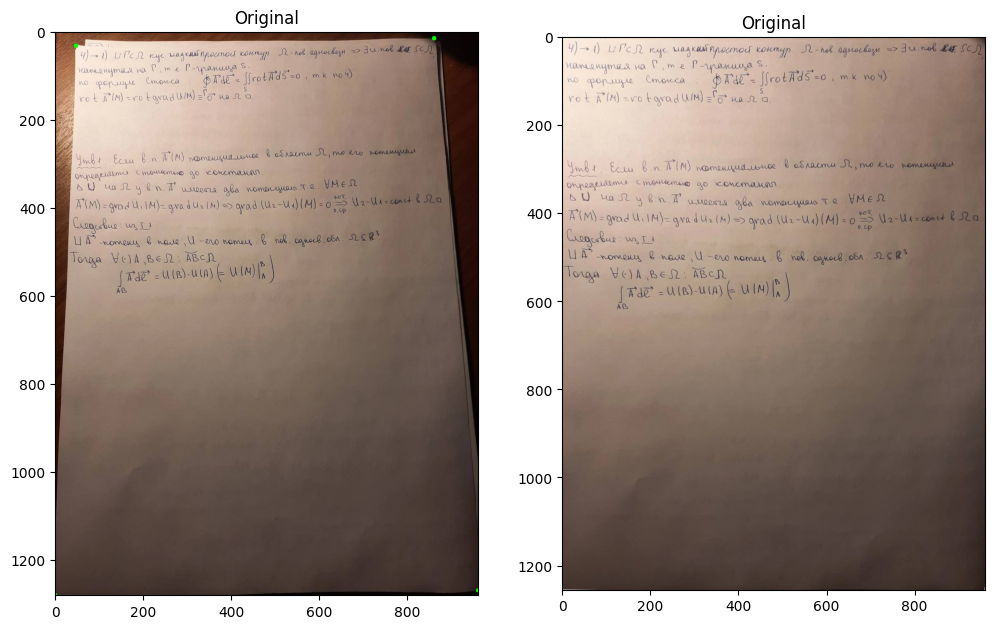

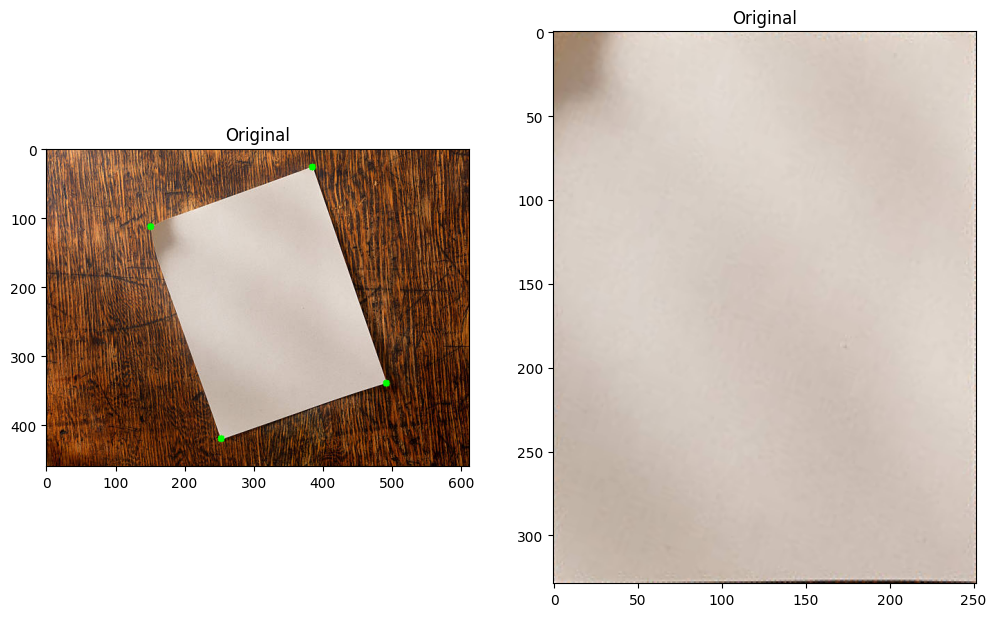

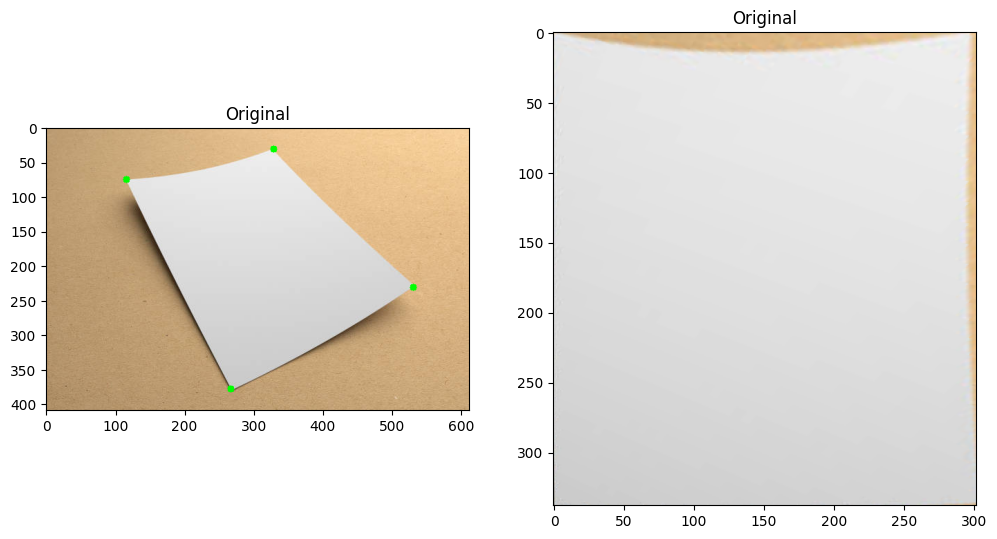

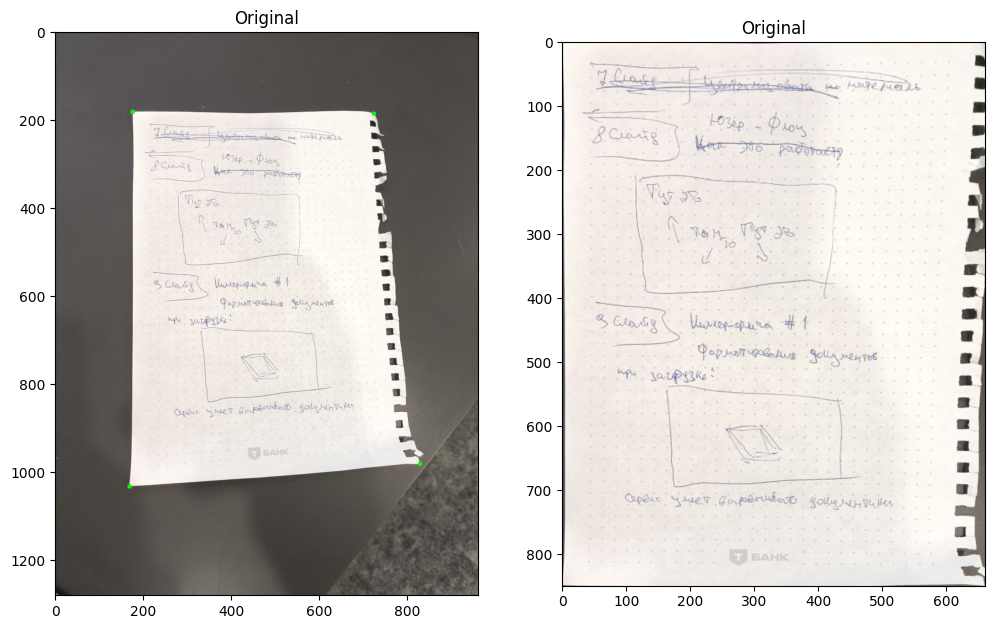

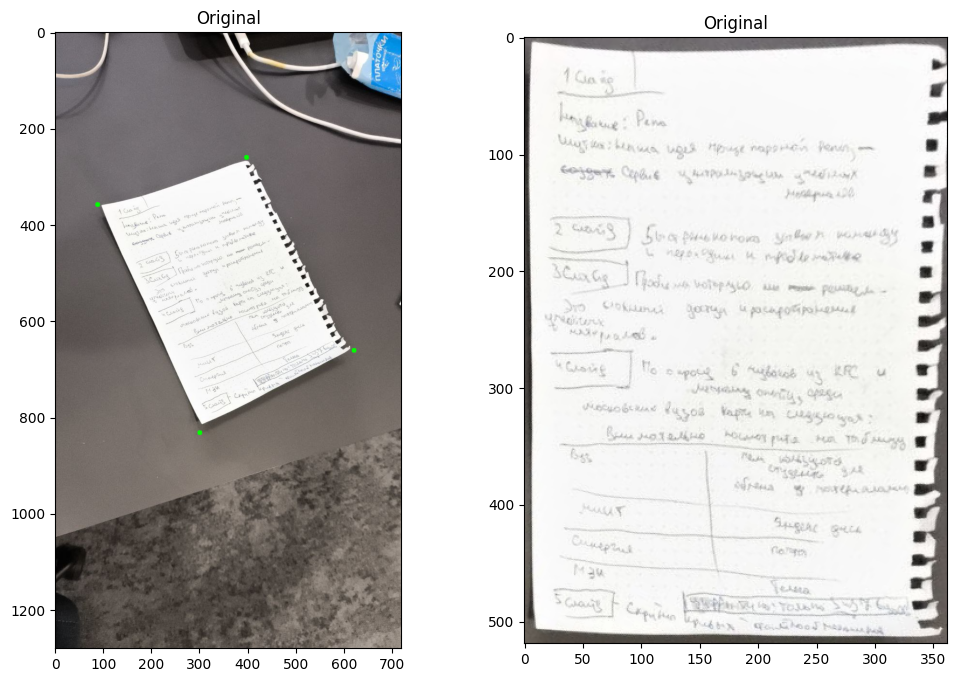

In [40]:
from find_contour import find_page_contour, align_img
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

names = ["kr3", "paper", "table2", "tb", "tb5"]
# names = ["anton2"]

for name in names:
  image = cv2.imread(f"../data/{name}.jpg")

  enchanced_img = find_page_contour(image, a=180, c=5)
  aligned_img = align_img(image, enchanced_img)
  aligned_img = enhance_text_readability(aligned_img)
  cv2.drawContours(image, enchanced_img.reshape(4, 1, 2), -1, (0, 255, 0), 10)

  # for point in enchanced_img:
  #   cv2.circle(image, point, 5, (0, 0, 255), -1)
  contour = np.array([[[50, 50]], [[450, 50]], [[450, 450]], [[50, 450]]])
  plt.figure(figsize=(12, 8))
  plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
  plt.subplot(122), plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)), plt.title('Original')